<a href="https://colab.research.google.com/github/zahBayat/ModelOnCMB/blob/main/Model_test3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
!pip install git+https://github.com/vafaei-ar/ccgpack.git

  Cloning https://github.com/vafaei-ar/ccgpack.git to /tmp/pip-req-build-0a4xlaqo
  Running command git clone -q https://github.com/vafaei-ar/ccgpack.git /tmp/pip-req-build-0a4xlaqo
  Created wheel for ccgpack: filename=ccgpack-0.1.0-cp37-cp37m-linux_x86_64.whl size=910059 sha256=8657d6d02e2e169628f98d5431e44d5653d9ce9478f6858e7a711329a65eea3e
  Stored in directory: /tmp/pip-ephem-wheel-cache-6p76hzs0/wheels/12/6f/95/7ae57565d174cea0e92a0da0a36f289e045f46ef2173da656b
Successfully built ccgpack


In [ ]:
import os
import numpy as np
import pylab as plt
from glob import glob
from random import choice,shuffle

In [ ]:
g_files = sorted(glob('/content/drive/MyDrive/Data/s4_patch/*.npy'))

if len(g_files)==0:
    print('Somthing is wrong with initiation.')
    #exit()

print(len(g_files))

300


In [ ]:
c=0 

for i in range(12):
    c+= np.std(np.load('/content/drive/MyDrive/Data/s4_patch/'+str(i)+'.npy'))
cmb_std = c/12
cmb_std

0.00011114208852328981

In [ ]:
def get_slice(data,nx,ny):
    """Slice matrix in x and y direction"""
    lx,ly = data.shape  
    if nx==0 or nx==lx:
        slx = slice(0, lx)                
    else:
        idx = np.random.randint(0, lx - nx)            
        slx = slice(idx, (idx+nx))       
    if ny==0 or ny==ly:
        sly = slice(0, ly)                
    else:
        idy = np.random.randint(0, ly - ny)            
        sly = slice(idy, (idy+ny))
    return slx, sly


class OrganizedDataProvider(object):
    def __init__(self,n_files,
                 s2n, cmb_std,
                 nx=0,ny=0,n_buffer=10,
                 reload_rate=100,filt=None ,test=0 , noisy=1):

        self.n_files = n_files
        self.test = test
        self.cmb_std = cmb_std 
        self.s2n = s2n
        self.noisy = noisy

        nmin = len(n_files)
        if n_buffer>= nmin:
            n_buffer = nmin
            self.reload_rate = 0
        else:
            self.reload_rate = reload_rate

        self.nx,self.ny = nx,ny
        self.n_buffer = n_buffer
        if filt is None:
            def filt(x):
                return x
        self.filt = filt
        self.counter = 0
        self.reload()
            
    def reload(self):
        print('Data provider is reloading...')
        self.n_set = []
    #        self.d_set = []
        nind = np.random.randint(0,len(self.n_files))


        for i in range(self.n_buffer):
            filen = self.n_files[nind]
            self.n_set.append(np.load(filen))
           

    def get_data(self): 
        self.counter += 1
        if self.reload_rate:
            if self.counter%self.reload_rate==0: 
                self.reload() 
    #        n = choice(self.n_set)
        ind = choice(np.arange(self.n_buffer))
        n = self.n_set[ind]


        return n

    def pre_process(self, n):
        
        nslice = get_slice(n,self.nx,self.ny)
        n = n[nslice]

        if self.noisy == 1:
            noise = np.random.normal(0, self.cmb_std/self.s2n ,n.shape)
            n = n +noise

        n = self.filt(n)

        return n

    def __call__(self, n, gmus=None): 


        X = []
        # Y = []

        for i in range(n):                
            n = self.get_data()

            sn  = self.pre_process(n)

            sn = (sn - np.mean(sn))/(np.std(sn) + 1e-30)
            sn = np.expand_dims(sn,-1)

            X.append(sn)
            #            Y.append(-np.log10(gmu+1e-30))
            # Y.append(lbl)

        X = np.array(X)
        # Y = np.array(Y)

        return X

In [ ]:
dofilt = 'n'

if dofilt[0]=='y':
    import ccgpack as ccg
    def filt(x):
        return ccg.filters(x,edd_method='sch')
else:
    filt = None

In [ ]:
odp = OrganizedDataProvider(g_files,
                              s2n = 20., 
                              cmb_std = cmb_std,
                              nx=256,ny=256,n_buffer=10,
                              reload_rate=1e5,filt=filt, noisy=1)


Data provider is reloading...


In [ ]:
# plt.figure(figsize = (5,5))
# plt.imshow(odp(200)[0,:,:,0] , cmap='jet')

In [ ]:
g_test = sorted(glob('/content/drive/MyDrive/TestData/s4_patch/*.npy'))

if len(g_test)==0:
    print('Somthing is wrong with initiation.')
#     exit()
print(len(g_test))

120


In [ ]:
odp_test = OrganizedDataProvider(g_test,
                                    s2n = 20., 
                                    cmb_std = cmb_std,
                                    nx=256,ny=256,n_buffer=10,
                                     reload_rate=1e5,filt=filt, noisy=1
                                 )

Data provider is reloading...


In [ ]:
y = odp_test(len(g_test))
y.shape

(120, 256, 256, 1)

# The Model

In [ ]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.models import Model

- preprocessing the data for out model

In [ ]:
def preprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """

    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 256, 256, 1))
    return array


def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(256, 256))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(256, 256))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()


In [ ]:
input = layers.Input(shape=(256, 256, 1))

# Encoder
z = layers.Conv2D(1, (3, 3), activation="relu", padding="same")(input)
z = layers.MaxPooling2D((2, 2), padding="same")(z)
z = layers.Conv2D(4, (3, 3), activation="relu", padding="same")(input)
z = layers.MaxPooling2D((2, 2), padding="same")(z)
z = layers.Conv2D(8, (3, 3), activation="relu", padding="same")(z)
z = layers.MaxPooling2D((2,2), padding="same")(z)
# z=z.add(Flatten(z))


# Decoder
z = layers.Conv2DTranspose(5, (3, 3), strides=2, activation="relu", padding="same")(z)
z = layers.Conv2DTranspose(2, (3, 3), strides=2, activation="relu", padding="same")(z)
z = layers.Conv2D(1, (2, 2), activation="sigmoid", padding="same")(z)

# z=layers.Dense(64)
# z=layers.Dense(1 , activation="sigmoid")

# z=z.add(Activation('sigmoid'))


# Autoencoder
autoencoder = Model(input, z)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 256, 256, 4)       40        
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 128, 128, 4)       0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 128, 128, 8)       296       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_transpose_16 (Conv2DT (None, 128, 128, 5)       365       
_________________________________________________________________
conv2d_transpose_17 (Conv2DT (None, 256, 256, 2)       92  

In [ ]:
epochs = 5

for i in range(epochs):
        x = odp(400)
        x_train = x
        train_data = preprocess(x_train)

        autoencoder.fit(x=train_data, y=train_data ,verbose=1, validation_split=0.2)


10/10 [==============================] - 1s 64ms/step - loss: 0.6591 - val_loss: 0.6534


In [ ]:
x_test = y
test_data = preprocess(x_test)

In [ ]:
autoencoder.evaluate(train_data, train_data)

13/13 [==============================] - 0s 25ms/step - loss: 0.6534


0.6534435153007507

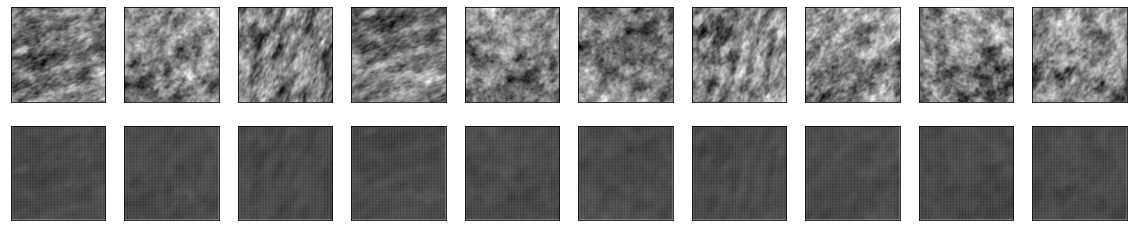

In [ ]:
train_prediction = autoencoder.predict(train_data)
display(train_data, train_prediction)